In order to estimate the frequency of >140m impactors, we narrowed down our crater data to only include craters within the lunar mare Oceanus Procellarum . Because we know the approximate age at which this lunar feature was formed, 1963 ± 57 million years ago (Che et al., 2021) , we can use the formation of this mare as an interval marker for the timeline of impacts to calculate an annual impact rate. 

In [3]:
# Import and read a dataset from an external file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sympy import Eq, Symbol, solve

craters = pd.read_csv("AstroStats_Robbins_Moon.csv", sep = ",")

#indexing from a certain row
print (craters[60:])

ModuleNotFoundError: No module named 'pandas'

A Monte Carlo simulation was applied to generate possible impactors of various diameters, velocities, densities, and impact angles. These randomly generated asteroids were used to create a distribution of resultant crater sizes. Craters whose sizes fell within the range of crater sizes for asteroids larger than 140m can then be ascertained. 

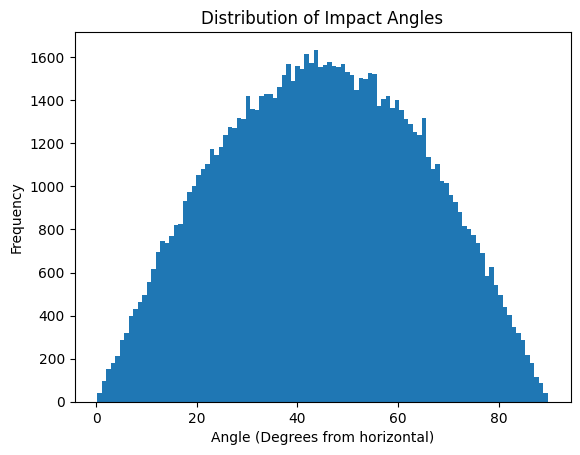

In [ ]:
# generate random impact scenarios for Monte Carlo modeling
import random # importing the Python random library

angles=[] #declare list
for _ in range(100000): # asking this to do stuff 10000 times
    u=random.uniform(0,1) # random number between 0 and 1
    angle=(90/np.pi)*np.arccos(2*u-1) # Distribution of angles according to Mathias et al.
    angles.append(angle)

plt.hist(angles, bins=100)
plt.xlabel('Angle (Degrees from horizontal)')
plt.ylabel('Frequency')
plt.title('Distribution of Impact Angles')
plt.show()

In [ ]:
# generate the ditribution of densities according to Mathias et al.
asteroid_densities=[3.38,3.3,3.19,2.27,6.75,7.15,2.84,3.12,2.86] # densities of different asteroid types
densities=[]

for _ in range(10000):
       # density=np.random.normal(np.mean(asteroid_densities[i]), np.std(std_densities[i]), size=None)
       # densities.append(density)
    density=min(asteroid_densities)*random.weibullvariate(1, 1.7)+1
    densities.append(density)


Text(0.5, 1.0, 'Density Distribution')

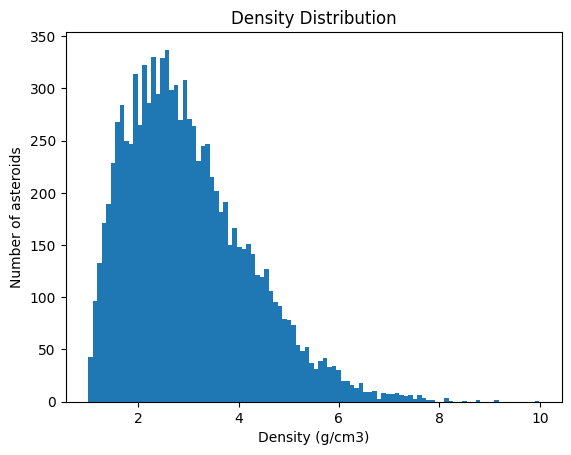

In [ ]:
plt.hist(densities, bins=100)
plt.xlabel('Density (g/cm3)')
plt.ylabel('Number of asteroids')
plt.title('Density Distribution')

Maximum velocity: 40.16 km/s


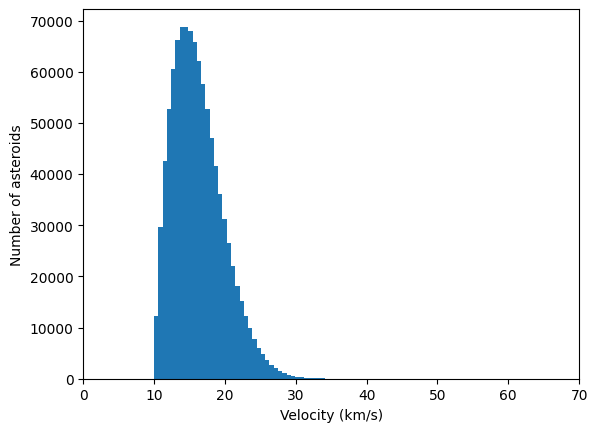

In [ ]:
#generate distribution of velocities

velocities=[]
for _ in range(1000000):
	velocity=10*random.weibullvariate(.7, 1.8)+10
	velocities.append(velocity)
# Let's check that this looks correct.
plt.hist(velocities,bins=50) #again we'll check the results to make sure they make sense
plt.xlabel("Velocity (km/s)") 
plt.ylabel("Number of asteroids")
plt.title('Velocity Distribution')
plt.xlim(0,70)
#Is the maximum value what we want it to be?
print("Maximum velocity:",'%.2f' %max(velocities),"km/s")


In [ ]:
from dbfread import DBF
from pandas import DataFrame

dbf = DBF('LROC_GLOBAL_MARE_360.dbf')
frame = DataFrame(iter(dbf))

print(frame.head())

   ID       MARE_NAME  Perimtr_km      Area_km
0   0        Endymion  447.162294  6514.848991
1   0   Mare Temporis  346.920443  1944.760025
2   0    Schumacher B   66.471067   266.591729
3   0  Lacus Temporis   42.048006    64.968201
4   0  Lacus Temporis   67.739731    49.136704


In [ ]:
# Check if craters are within the maria
import shapely
import fiona

crater_points=[]
# Create Point objects from coordinates


In [ ]:
# Find all craters likely caused by asteroids >140m
big_craters=[]
for crater in craters:

IndentationError: expected an indented block (3186309489.py, line 3)

In order to relate the craters in the database to the sizes of the asteroids that made them, a formula (Melosh, 1989) was used that relates the crater size, asteroid density, moon density, asteroid velocity, acceleration of gravity at the moon’s surface, and the angle of impact. The original equation solves for crater size, so a “solve” function was employed to find our single unknown using placeholder values. The distributions found earlier were then input into the equation to find all of the craters made by asteroids larger than 140 meters in the dataset.

In [ ]:
D_tc = 234 #PLACEHOLDER Crater diameter at level of ground surface (m)
rho_p = 6000  # PLACEHOLDER Density of asteroid (projectile)(kg/m^3)
rho_t = 2550 #Density of (moon) target (kg/m^3)
#L = 140 #SOLVING FOR -- Diameter of projectile (asteroid) (m)
v_i = 18 #PLACEHOLDER impact velocity (km/s)
g = 1.625 #surface gravity (m/s^2)
theta = 3.14159/2 #PLACEHOLDER impact angle, referencing from horizontal (rad)


L = Symbol('L')


a = Symbol('a')
b = Symbol('b')
c = Symbol('c')
d = Symbol('d')
e = Symbol('e')


a = (1.161*(rho_p/rho_t)**(1/3))
b = (L**.78)
c = (v_i**(0.44))
d = (g**(-0.22))
e = (math.sin(theta)**(1/3))




L = Symbol('L')
eqn = Eq(D_tc, a*b*c*d*e)




h = solve(eqn,L)
print (h)


NameError: name 'Symbol' is not defined

In [ ]:
# Import and read a dataset from an external file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


craters = pd.read_csv("AstroStats_Robbins_Moon.csv", sep = ",")

# Find all craters likely caused by asteroids >140m
min_crater_size=100 #Currently an arbitrary value


half_distance=30.221 #This distance is the number of degrees you would need to travel from the center of the mare to the side of an inscribed rectangle within it
center_long=302.6   #This is the longitude coordinate of the center of the mare
center_lat=18.4 #This is the latitude coordinate of the center of the mare


#The following lines calculate the bounds of the box we are observing
max_long=center_long+half_distance
min_long=center_long-half_distance
max_lat=center_lat+half_distance
min_lat=center_lat-half_distance


big_craters=craters[(craters["DIAM_CIRC_IMG"] >= min_crater_size)] #Filters out any craters smaller than the minimum size


#Filter out Longitudes out of our observation area
filtered_craters=big_craters[(big_craters["LON_CIRC_IMG"] >= min_long) & (big_craters["LON_CIRC_IMG"] <= max_long)]


#Filter out Latitudes out of our observation area
filtered_craters=filtered_craters[(filtered_craters["LAT_CIRC_IMG"] >= min_lat) & (filtered_craters["LAT_CIRC_IMG"] <= max_lat)]
print(filtered_craters)


